In [1]:
library(keras)
library(repr)

In [2]:
library(keras)
library(repr)

In [3]:
data.bkg  <- read.csv("data/P_LHCB_LambdaB/background.csv")
data.sig  <- read.csv("data/P_LHCB_LambdaB/MC_signal.csv")
data.lhcb <- read.csv("data/P_LHCB_LambdaB/data_lhcb.csv")

In [4]:
data.cutted.bkg  <-  data.bkg  %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)
data.cutted.sig  <-  data.sig  %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)
data.cutted.lhcb <-  data.lhcb %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)

In [29]:
# test set <- 400 sig 400 bkg

sel_features <- c(3, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18)
nt_bkg <- 400; nt_sig <- 400

x_test_bkg  <- as.matrix(data.bkg[1:nt_bkg, sel_features])
x_test_sig  <- as.matrix(data.sig[1:nt_sig, sel_features])

y_test_bkg  <- as.vector(matrix(0, nrow=nt_bkg, ncol=1))
y_test_sig  <- as.vector(matrix(1, nrow=nt_sig, ncol=1))

x_test  <- rbind(x_test_bkg  , x_test_sig  )
y_test  <-     c(y_test_bkg  , y_test_sig  )

x_test  <- scale(x_test )

shuffle_test  <- sample(nrow(x_test ))
x_test  <- x_test [shuffle_test,]
y_test  <- y_test [shuffle_test] 



In [30]:
#training set, dimension give with function

x_train_bkg_full <- as.matrix(data.bkg[-1:-nt_bkg, sel_features])
x_train_sig_full <- as.matrix(data.sig[-1:-nt_sig, sel_features])

y_train_bkg_full <- as.vector(matrix(0, nrow=nrow(x_train_bkg_full), ncol=1))
y_train_sig_full <- as.vector(matrix(1, nrow=nrow(x_train_sig_full), ncol=1))

get_train_data <- function(n_bkg, n_sig=1090 ){
    x_bkg <- x_train_bkg_full[1:n_bkg, ]
    x_sig <- x_train_sig_full[1:n_sig, ]
    x_t   <- rbind(x_bkg, x_sig)
    y_t   <- c(y_train_bkg_full[1:n_bkg], y_train_sig_full[1:n_sig])
    sffl  <- sample(nrow(x_t))
    
    x_t   <- x_t[sffl,]
    x_t   <- scale(x_t)
    y_t   <- y_t[sffl] 
    return (list(x_train=x_t, y_train=y_t))
}


In [31]:
# lhcb data
x_lhcb     <- as.matrix(       data.lhcb[, sel_features])
x_cut_lhcb <- as.matrix(data.cutted.lhcb[, sel_features])

x_lhcb     <- scale(x_lhcb)
x_cut_lhcb <- scale(x_cut_lhcb)


In [32]:
build_model <- function(params){
    model <- keras_model_sequential()
    model %>%
      layer_dense(units = params$unit1, activation = 'relu', 
                  input_shape = c(params$nFeat), 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout1) %>%
      layer_dense(units = params$unit2, activation = 'relu',  
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout2) %>%
      layer_dense(units = params$unit3, activation = 'relu', 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout3) %>%
      layer_dense(units = 1, activation = 'sigmoid')

    model %>% compile(
      loss = 'binary_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
    )
    return(model)
}

myParams <- flags(
    flag_numeric("dropout1", 0.1),
    flag_numeric("dropout2", 0.1),
    flag_numeric("dropout3", 0.1),
    flag_numeric("unit1", 128),
    flag_numeric("unit2", 64),
    flag_numeric("unit3", 32),
    flag_numeric("nFeat", length(sel_features)),
    flag_numeric("l1_coeff", 1e-4),
    flag_numeric("l2_coeff", 1e-5)
)

loss  accuracy 
0,5761754 0,8087500

`geom_smooth()` using formula 'y ~ x'


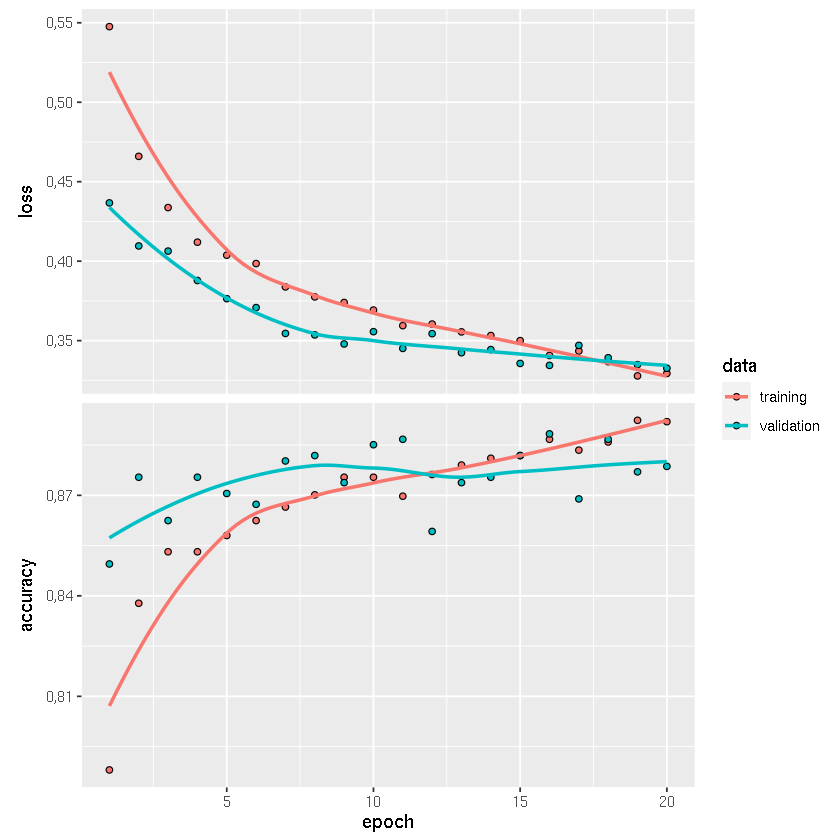

In [51]:
model <- build_model(myParams)
data  <- get_train_data(2000) 
history  <- model %>% fit (data$x_train, data$y_train, verbose=2,
                     epochs=20, batch_size=10, validation_split=0.2)
model %>% evaluate(x_test, y_test)
plot(history)

In [52]:
y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)

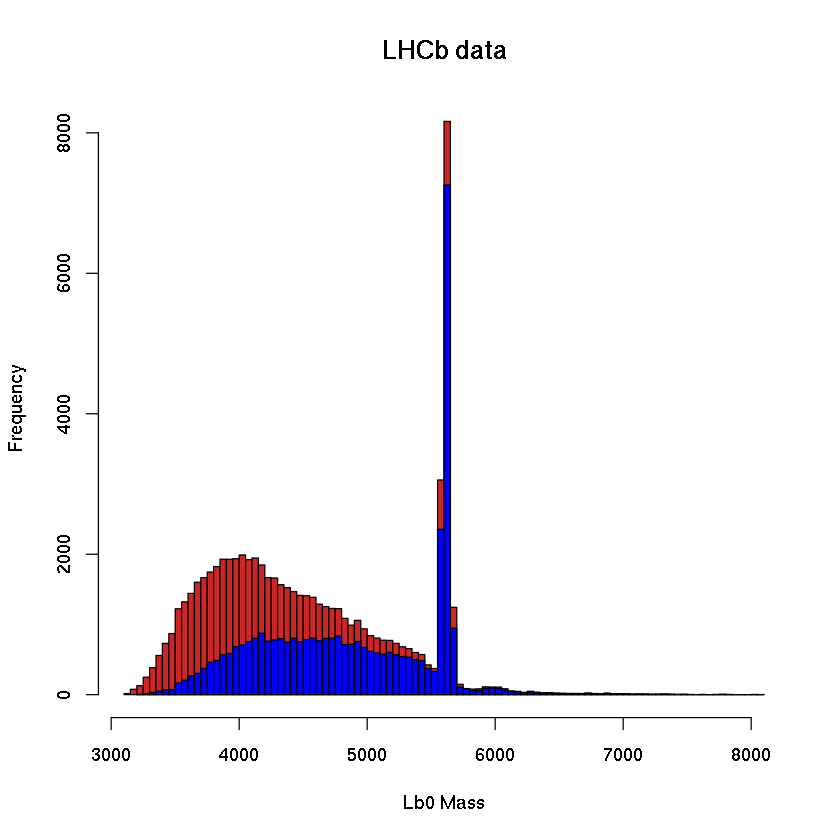

In [53]:
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.0],   breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.1], breaks=100, add=TRUE, col='blue')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.2], breaks=100, add=TRUE, col='green')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.3], breaks=100, add=TRUE, col='orange')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.5], breaks=100, add=TRUE, col='black')
